In [5]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis


In [6]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4
import rioxarray as rxr
from shapely.geometry import mapping
#plots
import matplotlib.pyplot as plt
import rioxarray 
import geopandas as gpd

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask

import scienceplots
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches  # For creating country legend handles
from matplotlib.patches import Circle
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


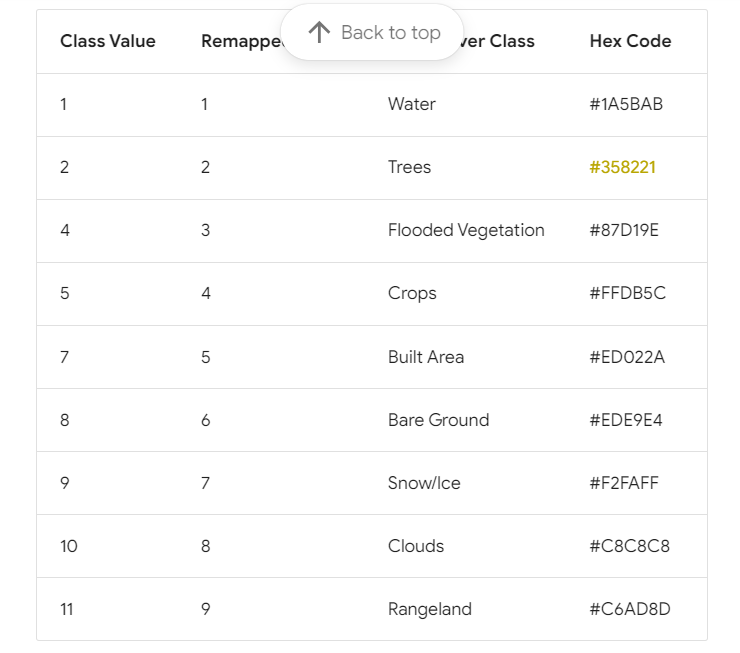
The data we got has 0 to 11 value (0,3,6 is not actual things and can be removed as reclassify)

#
# 1_LULC MAP Preprocessing

<xarray.DataArray (y: 3229, x: 3521)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 66.16 66.17 66.17 66.18 ... 97.75 97.76 97.77 97.78
  * y            (y) float64 37.08 37.07 37.06 37.05 ... 8.107 8.098 8.089 8.08
    spatial_ref  int32 0

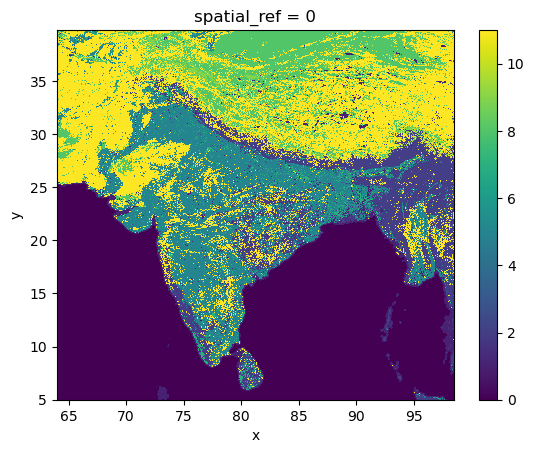

In [87]:
lulc = rxr.open_rasterio(f'DATA_r/5_LULC/ESRI_LULC_2020sa.tif')
lulc=lulc.mean(dim='band')
lulc.plot()

## Clipping to South Asia map
SA_map=gpd.read_file('DATA_p/shapefile/south_asia_p.shp')

#lulc.rio.set_spatial_dims(y_dim="y",x_dim="x", inplace=True)
#lulc.rio.write_crs("EPSG:4326", inplace=True)
lulc_clip = lulc.rio.clip(SA_map.geometry.apply(mapping), SA_map.crs, drop=True)
lulc_clip

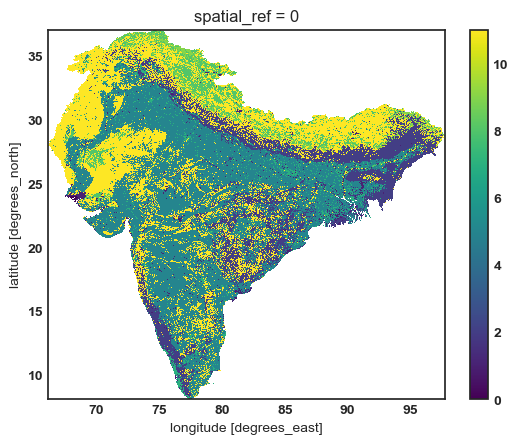

: 

In [120]:
#np.sum(lulc_clip.values==10)
#np.unique(lulc_clip)
lulc_clip.plot()

### 2 Reclassify to 6 classes for easiness


In [92]:
class_6= ['Built-up','Agricultural','Evergreen Broadleaf Forest','Shrubland-wasteland','Water bodeis','Ice-Glaciers']

lulc_clip1=lulc_clip.sel(x=lulc_clip.x.values[::4],y=lulc_clip.y.values[::4])
lulc_new=lulc_clip1.to_dataset(name='class')

my_class = {
    0: np.nan,  
    1: 1,  # Water -> 1
    2: 2,  # Trees -> 2
    3:np.nan,
    4: 3,  # Flooded Vegetation -> 3
    5: 4,  # Cropland -> 3 (Agricultural Land)
    6: np.nan,  
    7: 5,  # # Built-up area -> 4
    8: 6,  # Barren land -> desert
    9: 7,  # snow -> 5
    10: 8, # clouds
    11: 9  # Barelande -> 5
}


vec_fun=np.vectorize(my_class.get)
a=vec_fun(lulc_new['class'].values)
a = np.where(a == None, np.nan, a) 
a=a.astype(float)


lulc_new['remap'] = (('y', 'x'), a)


In [95]:
class_6= ['Built-up','Agricultural','Evergreen Broadleaf Forest','Shrubland/Wasteland','Water Bodeis','Ice-Glaciers']

## Again reclassified into 6 class for scn
my_class1 = {
    1: 50,  
    2: 30,  
    3:40,    
    4: 20,  
    5: 10,  
    6: 40,  
    7: 60,  
    8: np.nan, 
    9: 40  # snow -> 5
}

vec_fun=np.vectorize(my_class1.get)
a=vec_fun(lulc_new['remap'].values)
a = np.where(a == None, np.nan, a) 
a=a.astype(float)

lulc_new['class_6'] = (('y', 'x'), a)


In [107]:
## SAving the output
lulc_new.to_netcdf("DATA_p\LULC\ESRI_LULC_reclassified.nc")

#### Plotting LULC MAP

C:\Users\sstar\AppData\Local\Temp\ipykernel_17276\3660659210.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


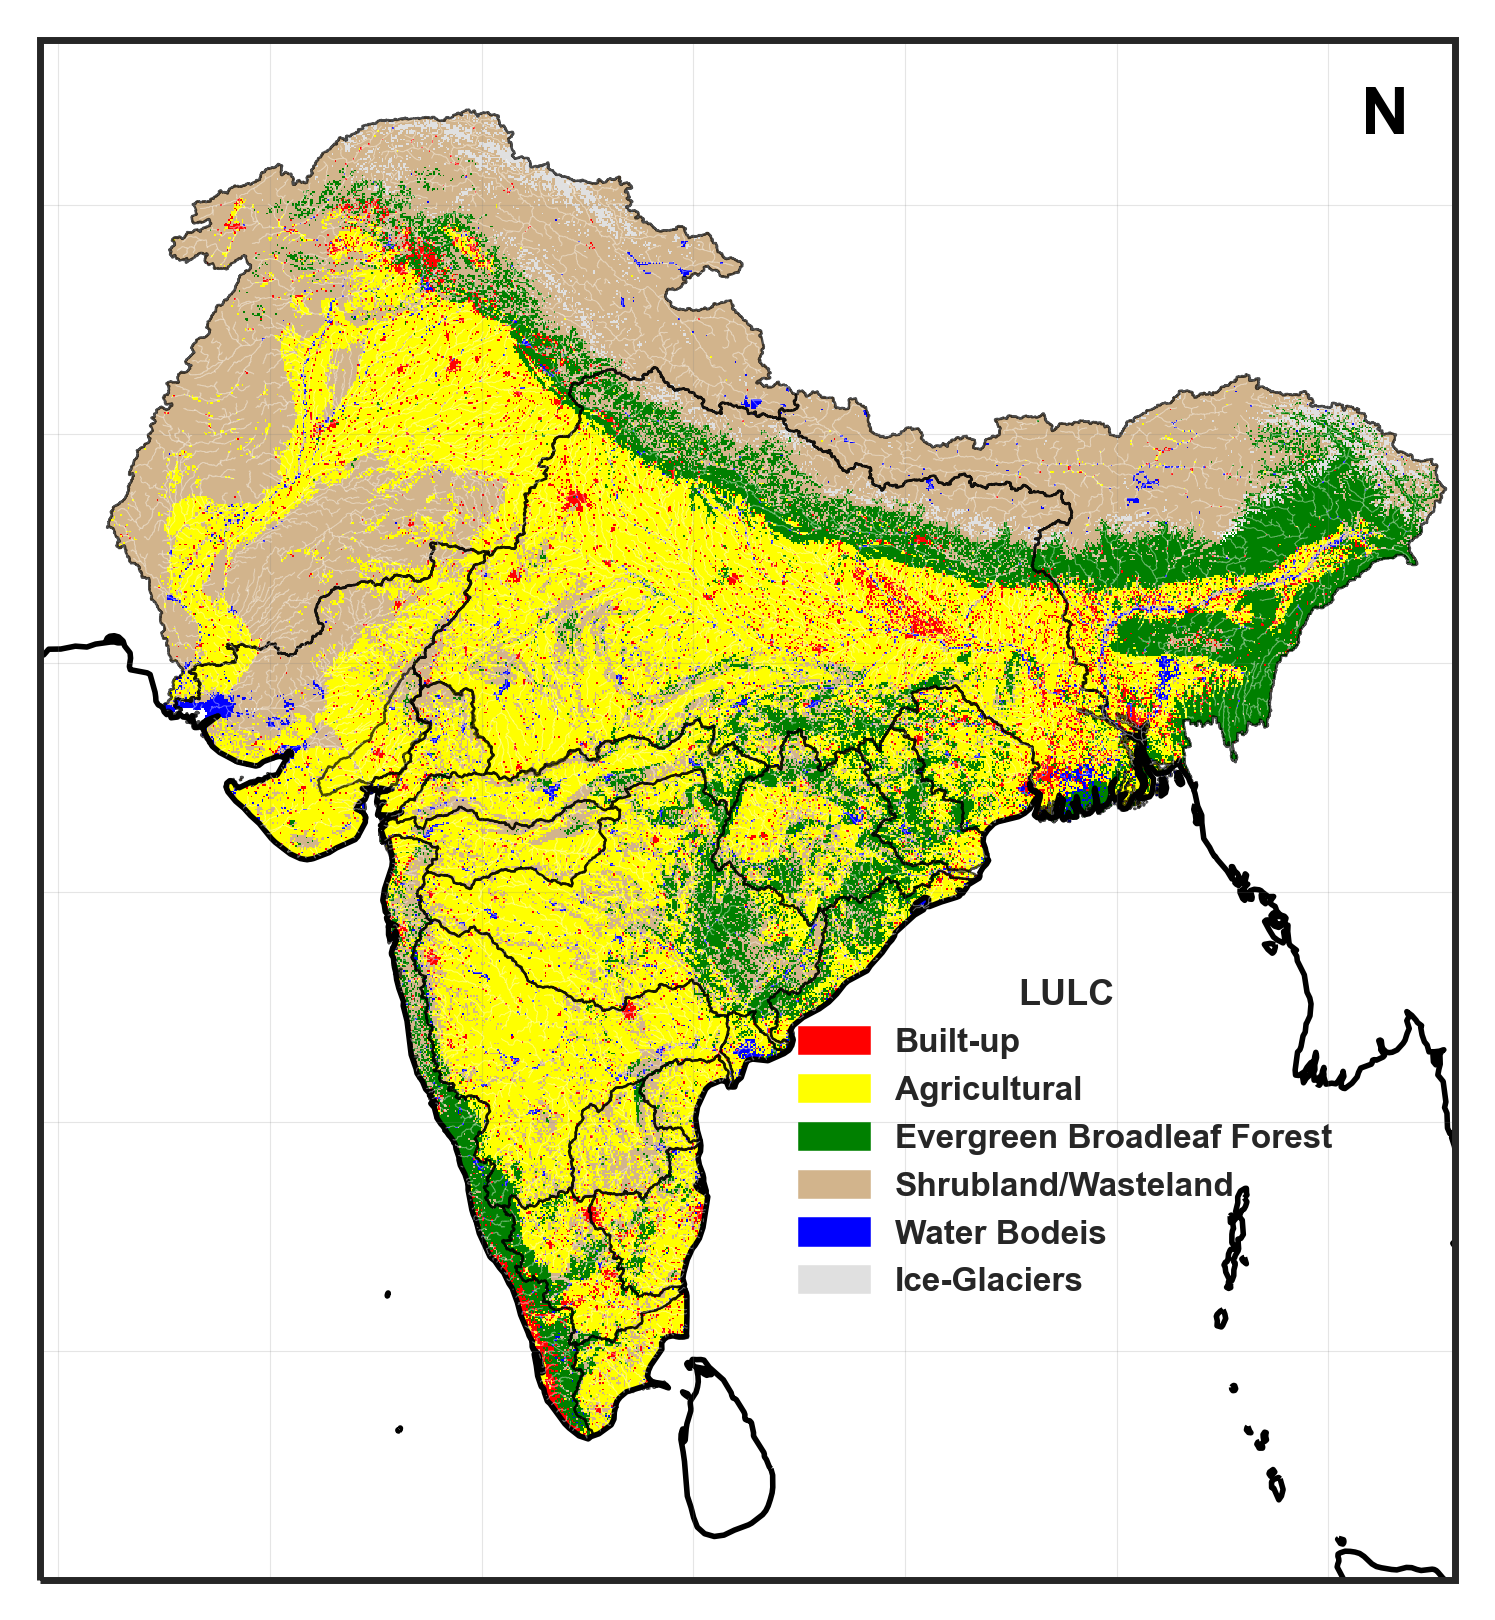

In [114]:
# Styling and font settings
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-white')

class_6= ['Built-up','Agricultural','Evergreen Broadleaf Forest','Shrubland/Wasteland','Water Bodeis','Ice-Glaciers']

ds=xr.open_mfdataset('DATA_p/Physiography/1_texture_classes.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
ds=ds.isel(x=np.arange(1,len(ds.x.values),3),y=np.arange(1,len(ds.y.values),3))

basin_map = gpd.read_file('DATA_r/shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('DATA_r/shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('DATA_r/shapefiles_new/india_admin/Country/India_country.shp')
south_asia=gpd.read_file('DATA_p/shapefile/south_asia_p.shp')


num_colors = 50;marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
basinEdge = 'black';basinEdge1 = 'blue'
basinLine = 0.35

# Creating the map plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": ccrs.PlateCarree()},
                       dpi=400, facecolor='white', constrained_layout=False)

ax.set_extent([64.571, 98, 5, 38.599], ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.2, color='grey', alpha=0.2, linestyle='-')


south_asia = south_asia.to_crs(ccrs.PlateCarree().proj4_init)


# Plot countries and rivers
num_classes=6

col=['red','yellow','green','#D2B48C','blue','#E0E0E0'] # You can also try 'tab20c' or 'Set3'
cmap = mcolors.ListedColormap(col)
bounds = [5, 15, 25, 35, 45, 55, 65]   # [1, 2, 3, ..., 12, 13]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


lulc_new['class_6'].plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
south_asia.plot(ax=ax, cmap=None, facecolor='none', edgecolor=basinEdge, linewidth=basinLine * 1.2, alpha=0.7)
riv_map.plot(ax=ax, color='white', alpha=0.4, linewidth=basinLine * 0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
#ax.add_feature(cfeature.OCEAN, color='lightblue')

# Add North arrow
ax.text(0.95, 0.95, 'N', fontsize=12, fontweight='bold', transform=ax.transAxes, ha='center', va='center', color='black')

# Country legend (with colored patches for each country)
legend_handles = [mpatches.Patch(color=col[i], label=class_6[i]) for i in range(num_classes)]
lg=ax.legend(handles=legend_handles, bbox_to_anchor=(0.934, 0.41), fontsize=6, title='LULC', title_fontsize=6.5,frameon=False)
#ax.add_artist(lg)

ax.set_title("")
# Save the plot
plt.savefig("lulc1.jpeg")


## 2_LULC MAP TREND ANALYSIS

In [9]:
dt_1 = pd.date_range(start='2000', end='2022', freq='Y').strftime('%Y-%m-%d')
dt_2 = pd.date_range(start='2000-01-01', end='2022-12-31', freq='A-JAN').strftime('%Y-%m-%d')


In [10]:


# Replace 'path/to/tif/files/*.tif' with the actual path to your .tif files
tif_files = glob.glob('DATA_r/5_LULC/*.tif')

# Create a list to store individual xarray DataArrays
data_arrays = []

# Load each .tif file into an xarray DataArray
for i,tif_file in enumerate(tif_files):
    data_array = rioxarray.open_rasterio(tif_file)
    data_array['time'] = dt_1[i]
    data_arrays.append(data_array)

# Concatenate the DataArrays along the time dimension (assuming they represent different time steps)
merged_data = xr.concat(data_arrays, dim='time')
lulc=merged_data.isel(band=0)
lulc=lulc.where(lulc>0)
lulc_dataset = lulc.to_dataset(name='lulc')
lulc_dataset.to_netcdf("DATA_p/NDVI_2000_2020.nc")

In [34]:
lulc_dataset['lulc']

<xarray.DataArray 'lulc' (time: 22, y: 391, x: 358)>
array([[[2486. , 2381.5, 2198.5, ..., 1444. , 1778. ,  853.5],
        [3044. , 2539. , 2341. , ...,  479. ,  470.5,  637. ],
        [3244.5, 3321.5, 2853.5, ..., 1555.5,  719.5,  660.5],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[2568. , 2135. , 2011. , ..., 1312. , 1593. ,  712. ],
        [2961. , 2350. , 2179. , ...,  479. ,  440. ,  599. ],
        [3207. , 3255. , 2851. , ..., 1373. ,  679. ,  621. ],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[3203. , 2490. , 2594. , ..., 1449. , 1758. ,  796. ],
        [3544. , 2971. , 2128. , ...,  538. ,  475. ,  630. ],
        [3835. , 3939. , 3392. , ..., 1311. ,  721. ,  654. ],
        ...,
...
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[3384. , 2478. , 2179. , ..., 1818. , 2015. , 1280. ],
        [4137. , 3521. , 2435. , ...,  830. ,  621. ,  765. ],
        [4211. , 4696. , 4294. , ..., 1752. ,  910. ,  743. ],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[2835. , 2211. , 1955. , ..., 1625. , 1837. , 1081. ],
        [3570. , 2691. , 1854. , ...,  773. ,  621. ,  746. ],
        [3782. , 4219. , 3664. , ..., 1673. ,  887. ,  735. ],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]]])
Coordinates:
    band         int32 1
  * x            (x) float64 66.97 67.06 67.15 67.24 ... 98.77 98.86 98.95 99.04
  * y            (y) float64 40.02 39.93 39.84 39.75 ... 5.255 5.165 5.075 4.986
    spatial_ref  int32 0
  * time         (time) <U10 '2000-12-31' '2001-12-31' ... '2021-12-31'
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

### GIF preparation

In [42]:
lulc=merged_data.isel(band=0)
lulc=lulc.where(lulc>0)

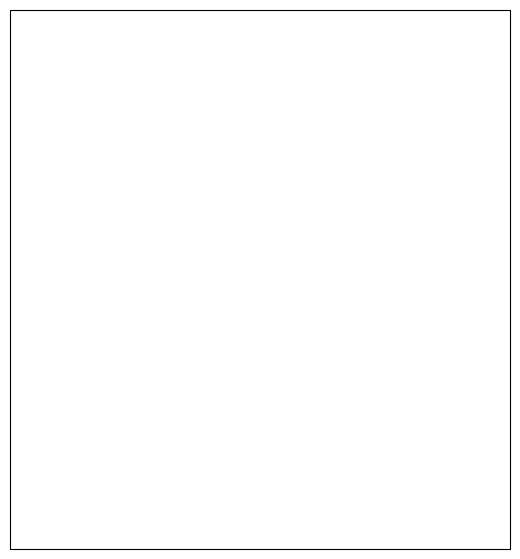

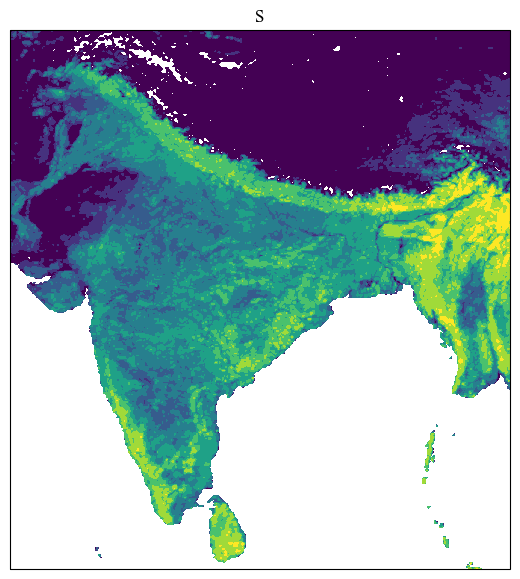

In [31]:
import matplotlib
import cartopy.crs as ccrs
import imageio
import animation
import matplotlib.animation as animation
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = 'Times New Roman' # setting default font

time1 = pd.date_range(start='2000', end='2022', freq='Y').strftime('%Y-%m-%d')

fig = plt.figure(figsize=(7,7))
axes = plt.axes(projection=ccrs.PlateCarree())
axes.set_extent([67.90, 97.59, 5.5, 37.50], ccrs.PlateCarree())

def animate(time):
    #print("hi")
    lulc.isel(time=time).plot.contourf(vmin=2000,vmax=8000 ,ax=axes, cmap='viridis', add_labels=False, add_colorbar=False) 
    #axes.add_feature(cfeature.STATES, zorder=1, linewidth=0.4, edgecolor='grey', linestyle='-.')
    plt.title("S")
    
ani = animation.FuncAnimation(fig, animate, 22, interval=1, blit=False)
ani.save('7_Revision Analysis/lulc_animation.gif', writer='pillow', fps=2, savefig_kwargs={"transparent": True, "facecolor": "none"})
plt.show()

In [38]:
lulc.time[0].values

array('2000-12-31', dtype='<U10')

# FUNCTIONS

In [30]:
def Multiple_plot(data,vmin1,vmax1,cmap2,labls):

    import numpy as np 
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import geopandas as gpd
    import matplotlib
    import xarray as xr
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.colors as clr
    import scienceplots
    import dask
  
    plt.style.use(['science','no-latex','bright'])


    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(3,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15.283,17),constrained_layout=False)
    axs=axs.flatten()



    #Loop over all of the models
    for i,model in enumerate(range(9)):

        
        #STEP 3 : LoaDING DATA
        xrr=data[i]
        basin_map = gpd.read_file('data_p/Shapefiles/Indian_basin/India_transboundary.shp')
        ind_map = gpd.read_file('data_p/Shapefiles/Indian_map/India_country.shp')
        
        
        
        # AXIS SETTING
        axs[i].set_extent([67.90, 97.59,5.4, 37.50], ccrs.PlateCarree())
       
        [x.set_linewidth(1.8) for x in axs[i].spines.values()]        #bOUNDARY WIDTHH 
        
        cmap1 = clr.LinearSegmentedColormap.from_list('blue_to_white', ['lightskyblue', '#FFFFFF'], N=256)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)
        axs[i].imshow(gradient, cmap=cmap1, extent=[67.90, 97.59,4.5, 37.50], transform=ccrs.PlateCarree())    
   
  


        # Adding Mainplo
        Main_plot=xrr.plot(vmin=vmin1,vmax=vmax1 ,ax=axs[i], cmap=cmap2, add_labels=False, add_colorbar=False,linewidth=4) 


        # Adding addition feature 
        axs[i].add_feature(cfeature.OCEAN,facecolor=("white"))#e0f3f8
        axs[i].add_feature(cfeature.LAND, linewidth=1, facecolor='white', edgecolor='black')
        basin_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=0.6,linestyle='--')
        ind_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=0.6,linestyle='--')


        # Title each subplot with the name of the model
        axs[i].set_title(f"{labls[i][0]} ({labls[i][1]})",fontsize=19,pad=12.5,fontname='Times New Roman',weight='bold')



    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.1, left=None, top=None, right=None, wspace=0.10, hspace=0.155)  

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.042, 0.6, 0.014])

    # Draw the colorbar
    cbar=fig.colorbar(Main_plot, cax=cbar_ax,orientation='horizontal') #,ticks=[0, 1,5]
    cbar.outline.set_linewidth(2) 
    cbar.ax.tick_params(axis='both',which='both', labelsize=17,width=1.5, length=9) 
    cbar.ax.tick_params(axis='both',which='minor', labelsize=11,width=0.6, length=5) 
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    #cbar.set_label(f"{labls[0][0]}{get_sub('La Nina')} - {labls[0][0]}{get_sub('El Nino')}", fontsize=24, labelpad=-65,weight="bold")#position=(0.5, -0.5)
    cbar.set_label(f"La Nina - El Nino", fontsize=24, labelpad=-65,weight="bold")#position=(0.5, -0.5)
    #plt.show()



# Testing 

In [144]:
lsm_anom.isel(lat=100,lon=50)

<xarray.DataArray 'TotalPrecip_tavg' (time: 504, month: 12)>
array([[ 0.74369604,  0.5737803 ,  0.60506373, ...,  0.73984769,
         1.06867355,  1.16546687],
       [-0.2869141 , -0.22136148, -0.23343047, ..., -0.28542943,
        -0.41228875, -0.44963111],
       [-0.12413233, -0.09577123, -0.10099283, ..., -0.12348999,
        -0.17837521, -0.19453124],
       ...,
       [ 2.73727645,  2.11187802,  2.22702101, ...,  2.72311207,
         3.93340128,  4.28966251],
       [-0.29395933, -0.22679706, -0.2391624 , ..., -0.2924382 ,
        -0.42241257, -0.46067189],
       [ 0.48017616,  0.37046805,  0.39066657, ...,  0.47769143,
         0.69000174,  0.75249749]])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    lat      float64 31.5
    lon      float64 79.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [163]:
aa=pd.DataFrame({'date':enso.index,'ppt':lsm_M['TotalPrecip_tavg'].isel(lat=100,lon=50),'ppt_norm':lsm_norm.isel(lat=100,lon=50)})
aa.to_csv('aa.csv')